# Concentration de CO2 dans l'atmosphère depuis 1958

Ce notebook montre la concetration de CO2 dans l'atmosphère depuis 1958 et fait une extrapolation sur les années à venir.

Ce notebook a été exécuté pour la dernière fois le :

In [1]:
import datetime
print(datetime.datetime.now())

2025-09-22 12:23:52.398459


## Importation des modules

In [2]:
%matplotlib inline
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

## Importation des données

In [3]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv"

In [4]:
filename = "monthly_in_situ_co2_mlo.csv"

if filename not in os.listdir():
    response = requests.get(data_url)
    
    with open(filename, "wb") as f:
        f.write(response.content)
    
raw_data = pd.read_csv(filename, skiprows=61, sep=",", na_values=-99.99)
raw_data.head(5)

Yr   Mn      Date         Date       CO2  seasonally          fit  \
0                                                adjusted                
1                Excel                  [ppm]      [ppm]         [ppm]   
2  1958   01     21200    1958.0411    -99.99      -99.99       -99.99   
3  1958   02     21231    1958.1260    -99.99      -99.99       -99.99   
4  1958   03     21259    1958.2027    315.71      314.43       316.20   

     seasonally           CO2       seasonally   Sta  
0  adjusted fit        filled  adjusted filled   NaN  
1         [ppm]         [ppm]            [ppm]   NaN  
2        -99.99        -99.99           -99.99   MLO  
3        -99.99        -99.99           -99.99   MLO  
4        314.91        315.71           314.43   MLO

## Nettoyage des données

In [5]:
raw_data.columns = ["Yr","Mn","Date_excel","Date","CO2","seasonally_adjusted","fit","seasonally_adjusted_fit","CO2_filled","seasonally_adjusted_filled","Sta"]

In [6]:
raw_data = raw_data.drop([0,1])
raw_data.head(5)

Yr   Mn Date_excel         Date       CO2 seasonally_adjusted  \
2  1958   01      21200    1958.0411    -99.99              -99.99   
3  1958   02      21231    1958.1260    -99.99              -99.99   
4  1958   03      21259    1958.2027    315.71              314.43   
5  1958   04      21290    1958.2877    317.45              315.15   
6  1958   05      21320    1958.3699    317.51              314.68   

           fit seasonally_adjusted_fit   CO2_filled  \
2       -99.99                  -99.99       -99.99   
3       -99.99                  -99.99       -99.99   
4       316.20                  314.91       315.71   
5       317.31                  314.99       317.45   
6       317.89                  315.07       317.51   

  seasonally_adjusted_filled   Sta  
2                     -99.99   MLO  
3                     -99.99   MLO  
4                     314.43   MLO  
5                     315.15   MLO  
6                     314.68   MLO

In [7]:
for col in ["CO2","seasonally_adjusted","fit","seasonally_adjusted_fit","CO2_filled","seasonally_adjusted_filled"]:
    raw_data[col] = raw_data[col].astype(float)
    
clean_data = raw_data[~raw_data.eq(-99.99).any(axis=1)]
clean_data.head(5)

Yr   Mn Date_excel         Date     CO2  seasonally_adjusted     fit  \
4  1958   03      21259    1958.2027  315.71               314.43  316.20   
5  1958   04      21290    1958.2877  317.45               315.15  317.31   
6  1958   05      21320    1958.3699  317.51               314.68  317.89   
8  1958   07      21381    1958.5370  315.87               315.20  315.85   
9  1958   08      21412    1958.6219  314.93               316.23  313.95   

   seasonally_adjusted_fit  CO2_filled  seasonally_adjusted_filled   Sta  
4                   314.91      315.71                      314.43   MLO  
5                   314.99      317.45                      315.15   MLO  
6                   315.07      317.51                      314.68   MLO  
8                   315.22      315.87                      315.20   MLO  
9                   315.29      314.93                      316.23   MLO

## Premier graphique de la concentration de CO2

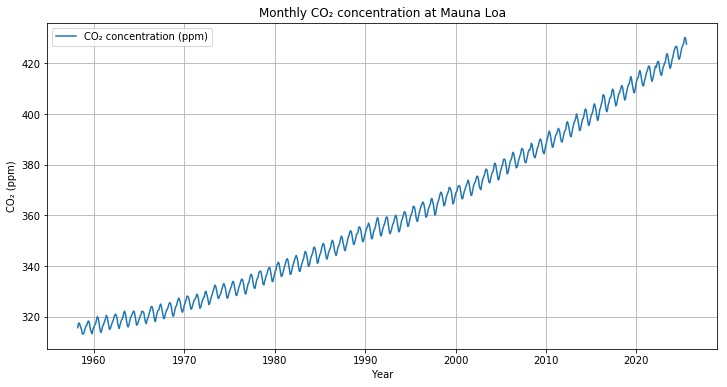

In [8]:
co2_data = clean_data.dropna(subset=["CO2"]).copy()
co2_data["date"] = pd.to_datetime(dict(year=clean_data["Yr"], month=clean_data["Mn"], day=15))

plt.figure(figsize=(12, 6))
plt.plot(co2_data["date"], co2_data["CO2_filled"], label="CO₂ concentration (ppm)")
plt.xlabel("Year")
plt.ylabel("CO₂ (ppm)")
plt.title("Monthly CO₂ concentration at Mauna Loa")
plt.legend()
plt.grid(True)
plt.show()

## Modèle de prediction pour extrapoler

In [9]:
# Préparation des variables
X = co2_data["date"].map(pd.Timestamp.toordinal).values.reshape(-1, 1)  # dates en nombres
y = co2_data["CO2"].values

# Modèle polynomial (ordre 3 par exemple)
degree = 3
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Prédictions sur données existantes
y_pred = model.predict(X)

# Prédictions futures (20 ans)
last_date = co2_data["date"].max()
future_dates = pd.date_range(start=last_date, periods=12*20, freq="M")
X_future = future_dates.map(pd.Timestamp.toordinal).values.reshape(-1, 1)
y_future = model.predict(X_future)

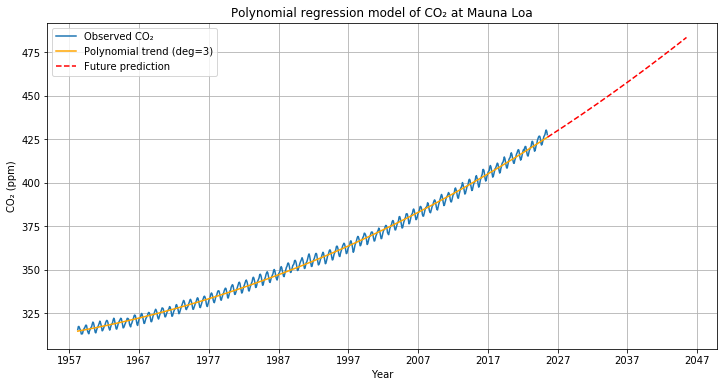

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(co2_data["date"], y, label="Observed CO₂")
plt.plot(co2_data["date"], y_pred, label=f"Polynomial trend (deg={degree})", color="orange")
plt.plot(future_dates, y_future, label="Future prediction", color="red", linestyle="--")
plt.xlabel("Year")
plt.ylabel("CO₂ (ppm)")
plt.title("Polynomial regression model of CO₂ at Mauna Loa")
plt.legend()
plt.grid(True)
plt.show()

Coefficients de la regression :

In [11]:
linreg = model.named_steps["linearregression"]

# Coefficients
print("Coefficients:", linreg.coef_)
print("Intercept:", linreg.intercept_)

Coefficients: [ 0.00000000e+00 -1.32833320e-13 -9.66139988e-08  9.14194538e-14]
Intercept: 16290.44586886284
